In [3]:
import os
import time
import uuid
# import opencv
import cv2
# import cv2

In [4]:
images_path = os.path.join('data1', 'images')
number_images = 30

In [5]:
cap = cv2.VideoCapture(1)

if not cap.isOpened():
    print("Camera not found or cannot be opened.")
else:
    for img_num in range(number_images):
        print('collecting image {}'.format(img_num))
        ret, frame = cap.read()
        
        if not ret:
            print("Failed to retrieve a frame from the camera.")
            break
        
        img_name = os.path.join(images_path, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(img_name, frame)
        cv2.imshow('frame', frame)
        time.sleep(0.5)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

Camera not found or cannot be opened.


In [6]:
# !labelme

In [7]:
import tensorflow as tf
import numpy as np
import json
from matplotlib import pyplot as plt

In [8]:

# # Directory containing the input images
# input_dir = "./data1/input_images"
# # Directory where resized images will be saved
# output_dir = "./data1/resized_img/"

# # Create the output directory if it doesn't exist
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # List of image file names in the input directory
# image_files = os.listdir(input_dir)

# # Specify the new dimensions (width and height)
# new_width = 1024  # Set the desired width
# new_height = 768  # Set the desired height

# # Iterate over the image files and resize each one
# for image_file in image_files:
#     # Load the image
#     image_path = os.path.join(input_dir, image_file)
#     image = cv2.imread(image_path)

#     # Resize the image
#     resized_image = cv2.resize(image, (new_width, new_height))

#     # Save the resized image to the output directory
#     output_path = os.path.join(output_dir, image_file)
#     cv2.imwrite(output_path, resized_image)

#     print(f"Resized and saved: {output_path}")

# # Optionally, release any openCV resources if necessary
# cv2.destroyAllWindows()


In [9]:
# img = cv2.imread(os.path.join('data1','train','images','B6DFE1D4-2D59-4804-9C7B-040FEE49076E.jpg'))
# img.shape

# Load image into TF data pipeline

In [10]:
images = tf.data.Dataset.list_files('data1\\input_images\\*.jpg')

In [11]:
images.as_numpy_iterator().next()
# `images.as_numpy_iterator().next()` is used to get the next batch of images from a TensorFlow dataset object called `images`. 

b'data1\\input_images\\IMG_20220710_185336.jpg'

In [12]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
images = images.map(load_image)

In [14]:
images.as_numpy_iterator().next()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [15]:
images.as_numpy_iterator().next()

array([[[234, 206, 182],
        [234, 206, 182],
        [233, 205, 181],
        ...,
        [226, 200, 183],
        [226, 199, 182],
        [228, 201, 184]],

       [[233, 205, 181],
        [233, 205, 181],
        [232, 204, 180],
        ...,
        [225, 199, 182],
        [225, 198, 181],
        [227, 200, 183]],

       [[233, 205, 181],
        [233, 205, 181],
        [233, 205, 181],
        ...,
        [225, 199, 182],
        [226, 199, 182],
        [229, 202, 185]],

       ...,

       [[225, 180, 141],
        [225, 180, 141],
        [224, 179, 140],
        ...,
        [246, 212, 177],
        [246, 212, 177],
        [245, 211, 176]],

       [[225, 180, 141],
        [224, 179, 140],
        [224, 179, 140],
        ...,
        [246, 212, 177],
        [246, 212, 177],
        [245, 211, 176]],

       [[225, 180, 141],
        [224, 179, 140],
        [224, 179, 140],
        ...,
        [246, 212, 177],
        [245, 211, 176],
        [244, 210, 175]]

In [16]:
images.as_numpy_iterator().next()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

we are getting the images in binary form

In [17]:
print(type(images))

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [18]:
image_generator = images.batch(4).as_numpy_iterator()

## Using Image Data Generator

In [19]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# path = os.path.join('data1', 'input_images')
# train_generator = train_datagen.flow_from_directory(
#     directory=path, 
#     target_size=(256,256), 
#     batch_size=4,
#     class_mode='categorical', 
#     subset='training')

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)),   
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), 1, activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), 1, activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])


Split the dataset for train and test

In [20]:
# import os
# import random
# import shutil
# SOURCE_DIR = os.path.join('data1', 'resized_img')
# # size = len(os.listdir(path))
# TRAINING_DIR = os.path.join('data1', 'train','images')
# VALIDATION_DIR = os.path.join('data1', 'val','images')
# TESTING_DIR = os.path.join('data1', 'test','images')
# image_list = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))
# train_size = 40
# test_size = 14
# val_size = 13
# for i,image_name in enumerate(image_list):
#     # image paths
#     img_path = os.path.join(SOURCE_DIR,image_name)
#     train_path = os.path.join(TRAINING_DIR,image_name)
#     val_path = os.path.join(VALIDATION_DIR,image_name)
#     test_path = os.path.join(TESTING_DIR,image_name)

#     if os.path.getsize(img_path)==0:
#       print(image_name," filename is zero length, so ignoring.")
#     else:
#       if i < train_size:
#         shutil.copyfile(img_path,train_path)
#       elif train_size <= i and i < val_size+train_size:
#         shutil.copyfile(img_path,val_path)
#       else:
#         shutil.copyfile(img_path,test_path)



Adding labels of images in to respective folders.


In [21]:
# for folder in ['train','val','test']:
# 	for file in os.listdir(os.path.join('data1',folder,'images')):
    
# 		filename = file.split('.')[0]+'.json'
# 		existing_filepath = os.path.join('data1','resized_label',filename)
# 		if os.path.exists(existing_filepath):
# 			new_filepath = os.path.join('data1',folder,'labels',filename)
# 			shutil.copyfile(existing_filepath,new_filepath)
  

Apply Image Augmentation

In [22]:
import albumentations as A

In [23]:
img = cv2.imread(os.path.join('data1','train','images','IMG_0886.jpg'))

img.shape

(768, 1024, 3)

In [24]:
augmentor = A.Compose(
    [
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(p=0.2),
    A.VerticalFlip(p=0.5),
    A.RandomGamma(p=0.2),
    ],
    bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels']),
    )


In [25]:
img = cv2.imread(os.path.join('data1','train','images','B6DFE1D4-2D59-4804-9C7B-040FEE49076E.jpg'))
img

array([[[105, 113,  96],
        [105, 113,  96],
        [108, 114,  97],
        ...,
        [152, 160, 143],
        [156, 164, 147],
        [163, 169, 152]],

       [[120, 128, 111],
        [120, 128, 111],
        [120, 126, 109],
        ...,
        [141, 149, 132],
        [145, 153, 136],
        [151, 157, 140]],

       [[137, 143, 126],
        [123, 129, 112],
        [107, 113,  96],
        ...,
        [148, 156, 139],
        [145, 151, 134],
        [140, 146, 129]],

       ...,

       [[174, 187, 189],
        [180, 193, 195],
        [184, 197, 199],
        ...,
        [200, 212, 216],
        [197, 209, 213],
        [193, 205, 211]],

       [[177, 191, 190],
        [182, 196, 195],
        [183, 197, 196],
        ...,
        [196, 208, 212],
        [201, 213, 219],
        [201, 213, 219]],

       [[173, 187, 186],
        [171, 185, 184],
        [168, 182, 181],
        ...,
        [197, 209, 215],
        [189, 201, 207],
        [178, 190, 196]]

In [26]:
type(img)

numpy.ndarray

In [27]:
img.shape

(768, 1024, 3)

In [28]:
with open(os.path.join('data1','train','labels','B6DFE1D4-2D59-4804-9C7B-040FEE49076E.json')) as f:
	data = json.load(f)

In [29]:
label = data['shapes'][0]['label']
points = data['shapes'][0]['points']
coords = [0,0,0,0]
coords[0] = points[0][0]
coords[1] = points[0][1]
coords[2] = points[1][0]
coords[3] = points[1][1]
coords

[380.37606837606836, 283.57264957264954, 480.37606837606836, 344.2564102564102]

In [30]:
coords = list(np.divide(coords, [ 1024, 768, 1024, 768]))
coords

[0.37146100427350426,
 0.36923522079772075,
 0.46911725427350426,
 0.4482505341880341]

In [31]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [32]:
augmented['class_labels']


['face']

In [33]:
augmented['image'].shape

(450, 450, 3)

In [34]:
augmented['bboxes']
# these coordinates will differ from our aw coordinates as we have resized the image

[(0.40360873694207033,
  0.27238366571699896,
  0.6258309591642925,
  0.40723646723646717)]

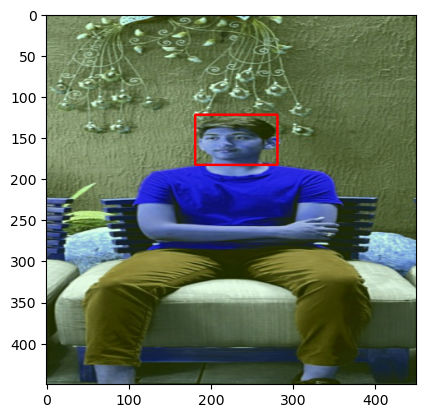

In [35]:
cv2.rectangle(
    augmented['image'],
    tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
	tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
	(255,0,0),2
 	)

plt.imshow(augmented['image'])

we have built an augmentation pipeline for a single image

# Build and Run a full scale Augmentation Pipeline

In [36]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data1',partition,'images')):
        # Load the image
        img = cv2.imread(os.path.join('data1',partition, 'images', image))
        # Coordinates for bounded boxes in images with no annotations.
        coords = [0,0,0.00001,0.00001]
        # Load the label
        label_path = os.path.join('data1',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            # uses a context manager to open the file as read only mode'r' and assign the file to f.
            with open(label_path,'r') as f:
                # read the content of file and convert it to json.
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [ 1024, 768, 1024, 768]))
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                # save the augmented image using imwrite
                cv2.imwrite(os.path.join('aug_data',partition,'images',f"{image.split('.')[0]}_{x}.jpg"),augmented['image'])
                annotations = {}
                #save image name in annotations dictionary
                annotations['image'] = image
                #save coordinates in annotations dictionary
                if os.path.exists(label_path):
                    if len(augmented['bboxes'])==0:
                        #if there is no bounding box in the image then set the coordinates to 0 and class to 0-> no BBox
                        annotations['bbox'] = [0,0,0,0]
                        annotations['class'] = 0
                    else:
                        #if there is bounding box in the image then set the coordinates to the bounding box and class to 1-> BBox
                        annotations['bbox'] = augmented['bboxes'][0]
                        annotations['class'] = 1
                else:
                    #if there is no bounding box in the image then set the coordinates to 0 and class to 0-> no BBox
                    annotations['bbox'] = [0,0,0,0]
                    annotations['class'] = 0
                path = os.path.join('aug_data',partition,'labels',f'{image.split(".")[0]}.{x}.json')
                # opening the file at path for writing 
                with open(path, 'w') as f:
                    # the content of the annotations dictionary will be serialized to JSON and saved in the specified file.
                    json.dump(annotations, f)
                    
        except Exception as e:
            print(e)

In [37]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [38]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [39]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [40]:
im = train_images.as_numpy_iterator().next()
im

array([[[0.8989583 , 0.9028799 , 0.84797794],
        [0.88235295, 0.8862745 , 0.83137256],
        [0.8791054 , 0.88302696, 0.828125  ],
        ...,
        [0.15618873, 0.32647058, 0.3560049 ],
        [0.16292892, 0.3253064 , 0.35784313],
        [0.159375  , 0.3122549 , 0.35502452]],

       [[0.88848037, 0.89240193, 0.8375    ],
        [0.9166054 , 0.920527  , 0.865625  ],
        [0.9142157 , 0.91813725, 0.8632353 ],
        ...,
        [0.25349265, 0.4471201 , 0.5020221 ],
        [0.24791667, 0.45232844, 0.503799  ],
        [0.29693627, 0.5002451 , 0.54632354]],

       [[0.93088233, 0.9348039 , 0.87990195],
        [0.9283701 , 0.9322917 , 0.8773897 ],
        [0.9175245 , 0.9214461 , 0.8665441 ],
        ...,
        [0.26409313, 0.46801472, 0.5229167 ],
        [0.2963848 , 0.50036764, 0.5518382 ],
        [0.32769608, 0.5065564 , 0.5346814 ]],

       ...,

       [[0.5935049 , 0.6719363 , 0.63664216],
        [0.5264706 , 0.60490197, 0.56960785],
        [0.5767157 , 0

In [41]:
im.shape

(120, 120, 3)

In [42]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r',encoding="utf-8") as f:
        label = json.load(f)
    return [label['class']],label['bbox']

In [43]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
# .map() is used to transform each element of the dataset.
# lambda x is func used for mapping
# x is element from train_labels list -> path to files.
# tf.py_function() is used to execute a Python function (load_labels) as part of a TensorFlow graph. It allows you to apply arbitrary Python code to the elements of a TensorFlow dataset.
# tout is defining datatypes of the output of the function
train_labels = train_labels.map(lambda x: tf.py_function(func=load_labels, inp = [x], Tout=[tf.uint8, tf.float16]))

In [44]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(func=load_labels, inp = [x], Tout=[tf.uint8, tf.float16]))

In [45]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(func=load_labels, inp = [x], Tout=[tf.uint8, tf.float16]))

In [46]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)


(2400, 2400, 840, 840, 780, 780)

In [47]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(3000)
train = train.batch(8)
train = train.prefetch(4)

In [48]:

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [49]:

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [50]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.502 , 0.558 , 1.    , 0.882 ],
        [0.9014, 0.2595, 1.    , 0.3943],
        [0.4724, 0.768 , 0.8174, 0.953 ],
        [0.    , 0.1019, 0.4436, 0.4717],
        [0.1655, 0.4336, 0.5933, 0.739 ],
        [0.5103, 0.7104, 0.9404, 1.    ],
        [0.537 , 0.    , 1.    , 0.2451],
        [0.4346, 0.4792, 0.829 , 0.7246]], dtype=float16))

In [51]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


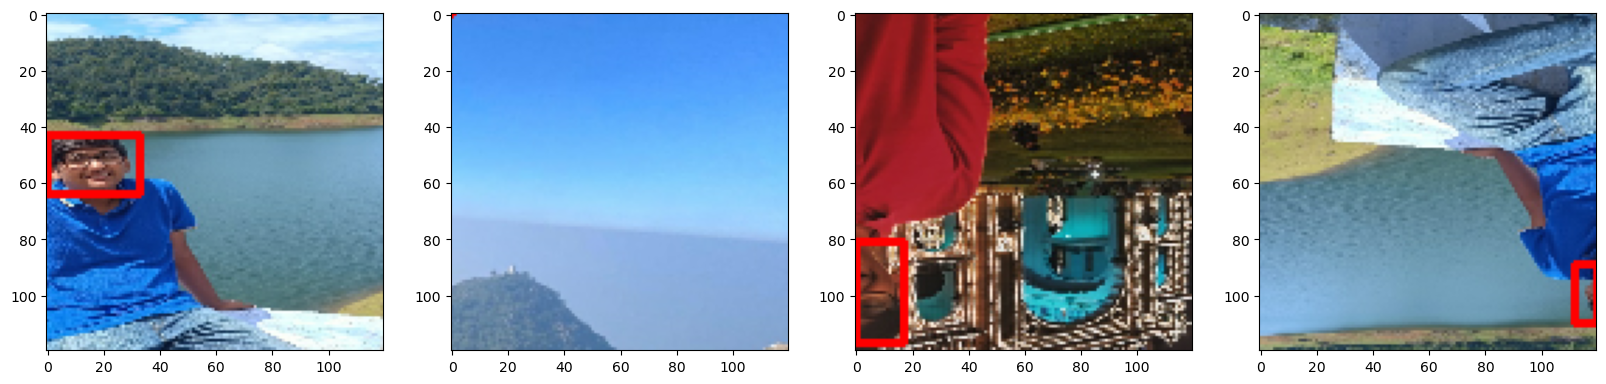

In [52]:
fig,ax = plt.subplots(ncols = 4, figsize = (20,20))
for i in range(4):
    sample_img = res[0][i]
    sample_coords = res[1][1][i]
    cv2.rectangle(
        sample_img, 
        tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)), 
        tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
        (255,0,0), 2)
    ax[i].imshow(sample_img)

# Build DL model using Functional API

In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [54]:
vgg = VGG16(include_top = False)
# include top get rid of the final layers in vgg16 model which classifies the image in last layers of model.

58889256/58889256 [==============================] - 9s 0us/step


In [55]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [153]:
# we are using functional api instead of sequential api because there are 2 outputs.
input_layer = Input(shape=(120,120,3))
vgg = VGG16(include_top=False)(input_layer)

f1 = GlobalMaxPooling2D()(vgg)
class1 = Dense(2048,activation='relu')(f1)
class2 = Dense(1,activation='sigmoid')(class1)

f2 = GlobalMaxPooling2D()(vgg)
regress1 = Dense(2048,activation='relu')(f2)
regress2 = Dense(4,activation='sigmoid')(regress1)
# after vgg processes the data, we will have its output passed to 2 2 different dense layers for 2 different outputs
# 4 units will give the coordinbates of bbox.
faceTracker = Model(inputs = input_layer, outputs = [class2,regress2])
# we need 2 types of outputs -> classifiaction and regression
# classification gives the probability of the image being a face
# regression gives the coordinates of the face/ bounding box    

In [154]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.6294 , 0.2913 , 0.9014 , 0.4636 ],
        [0.783  , 0.04257, 1.     , 0.348  ],
        [0.     , 0.1392 , 0.3806 , 0.5547 ],
        [0.5474 , 0.435  , 0.7695 , 0.57   ],
        [0.2075 , 0.453  , 0.816  , 0.8223 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.3445 , 0.2632 , 0.7725 , 0.5684 ],
        [0.     , 0.3794 , 0.554  , 0.9443 ]], dtype=float16))

In [156]:
faceTracker

In [157]:
faceTracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_6[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [158]:
x,y = train.as_numpy_iterator().next()
classes,coords = faceTracker.predict(x)
classes,coords

1/1 [==============================] - 1s 599ms/step


(array([[0.6082675 ],
        [0.48862347],
        [0.611119  ],
        [0.60684234],
        [0.57206327],
        [0.49932638],
        [0.6457946 ],
        [0.6230369 ]], dtype=float32),
 array([[0.5410215 , 0.3305417 , 0.5387926 , 0.6933055 ],
        [0.3789539 , 0.41664168, 0.65481997, 0.62689364],
        [0.42699274, 0.44679278, 0.49126545, 0.5362501 ],
        [0.42074478, 0.39657322, 0.57917726, 0.6752183 ],
        [0.41142657, 0.34121788, 0.7126756 , 0.7278228 ],
        [0.43784788, 0.3478382 , 0.50793016, 0.6584059 ],
        [0.46022597, 0.37701315, 0.53761137, 0.61006725],
        [0.28951272, 0.3611975 , 0.7267068 , 0.576862  ]], dtype=float32))

# Defining Losses & Optimizers

In [61]:
len(train)

300

In [62]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch
opt = tf.optimizers.legacy.Adam(learning_rate=0.0001,decay = lr_decay)
# learning rate controls the step size of the gradient descent
# decay is used to reduce the learning rate over time such that it improves convergence of training

In [63]:
lr_decay

0.001111111111111111

In [64]:
def localization_loss(ytrue,yhat):
    delta_coord = tf.reduce_sum(tf.square(ytrue[:,:2] - yhat[:,:2]))

    htrue = ytrue[:,3] - ytrue[:,1]
    wtrue = ytrue[:,2] - ytrue[:,0]
    hpred = yhat[:,3] - yhat[:,1]
    wpred = yhat[:,2] - yhat[:,0]	
    
    delta_size = tf.reduce_sum(tf.square(wtrue - wpred) + tf.square(htrue - hpred))

    return delta_coord + delta_size

In [65]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

In [66]:
print(localization_loss(y[1],coords).numpy())
class_loss(y[0],classes).numpy()

3.7982552


0.87320185

In [146]:
# Custom Keras Model Class
# subclassing the model class from keras -> parent class is tf.keras.Model
# this needs a init,compile, train_step and call method.
class FT(Model): 
    # passing inital params to model class, here we are passing our pre built nn. when we call FT, it will call the model class and pass the params to it.
    # super() is used to call the parent class.
    def __init__(self, eyetracker,**kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker
    #
    def compile(self, opt, classloss, localizationloss,**kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch,**kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            print("1: ",self.model(X))
            classes, coords = self.model(X)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
        grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [160]:
model = FT(faceTracker)

In [181]:
model.compile(opt, class_loss, regress_loss,metrics=["accuracy"])

In [182]:
logdir='logs'

In [183]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [184]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


1:  [<tf.Tensor 'model_2/dense_9/Sigmoid:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'model_2/dense_11/Sigmoid:0' shape=(None, 4) dtype=float32>]
300/300 [==============================] - 742s 2s/step - total_loss: 0.0393 - class_loss: 0.0076 - regress_loss: 0.0355 - val_total_loss: 3.0268 - val_class_loss: 1.7644 - val_regress_loss: 2.1446
Epoch 2/10
300/300 [==============================] - 694s 2s/step - total_loss: 0.0298 - class_loss: 0.0055 - regress_loss: 0.0271 - val_total_loss: 0.5870 - val_class_loss: 0.6144 - val_regress_loss: 0.2798
Epoch 3/10
300/300 [==============================] - 691s 2s/step - total_loss: 0.0320 - class_loss: 0.0061 - regress_loss: 0.0289 - val_total_loss: 0.5999 - val_class_loss: 0.4609 - val_regress_loss: 0.3694
Epoch 4/10
300/300 [==============================] - 683s 2s/step - total_loss: 0.0214 - class_loss: 0.0027 - regress_loss: 0.0201 - val_total_loss: 0.0115 - val_class_loss: 0.0017 - val_regress_loss: 0.0107
Epoch 5/10
187/300 [=======

KeyboardInterrupt: 

In [185]:
hist.history

{'total_loss': [1.0861084461212158,
  0.5774233341217041,
  0.8801990151405334,
  0.0749254897236824,
  0.03935003653168678,
  0.0567033626139164,
  0.047100093215703964,
  0.02122524566948414,
  0.010967986658215523,
  0.03471796587109566],
 'class_loss': [0.21146060526371002,
  0.20185451209545135,
  0.4531586468219757,
  0.02196509763598442,
  0.01786721497774124,
  0.0141685102134943,
  0.002421807264909148,
  0.0061252363957464695,
  0.0007327046478167176,
  0.03866706043481827],
 'regress_loss': [0.9803781509399414,
  0.4764960706233978,
  0.6536197066307068,
  0.06394293904304504,
  0.030416429042816162,
  0.04961910843849182,
  0.04588919132947922,
  0.018162626773118973,
  0.010601634159684181,
  0.015384435653686523],
 'val_total_loss': [1.2424708604812622,
  0.18535608053207397,
  0.28913968801498413,
  0.9035616517066956,
  0.5037969350814819,
  1.9261791706085205,
  1.273195743560791,
  0.1250820904970169,
  0.00811406783759594,
  0.18550388514995575],
 'val_class_loss': [

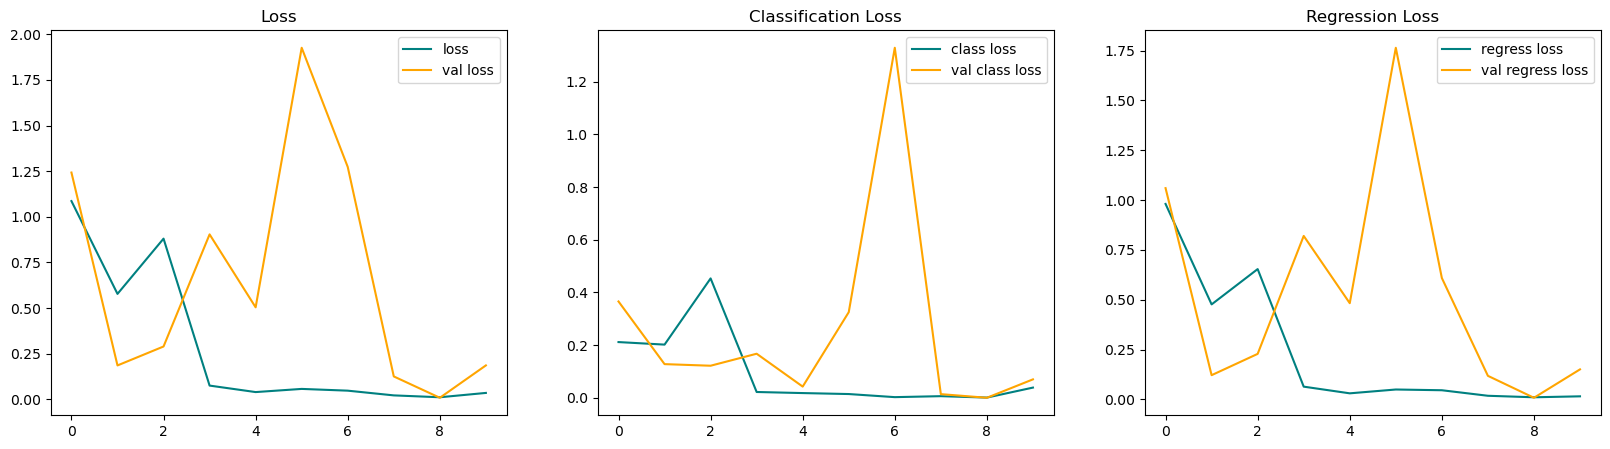

In [186]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [199]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model(test_sample[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


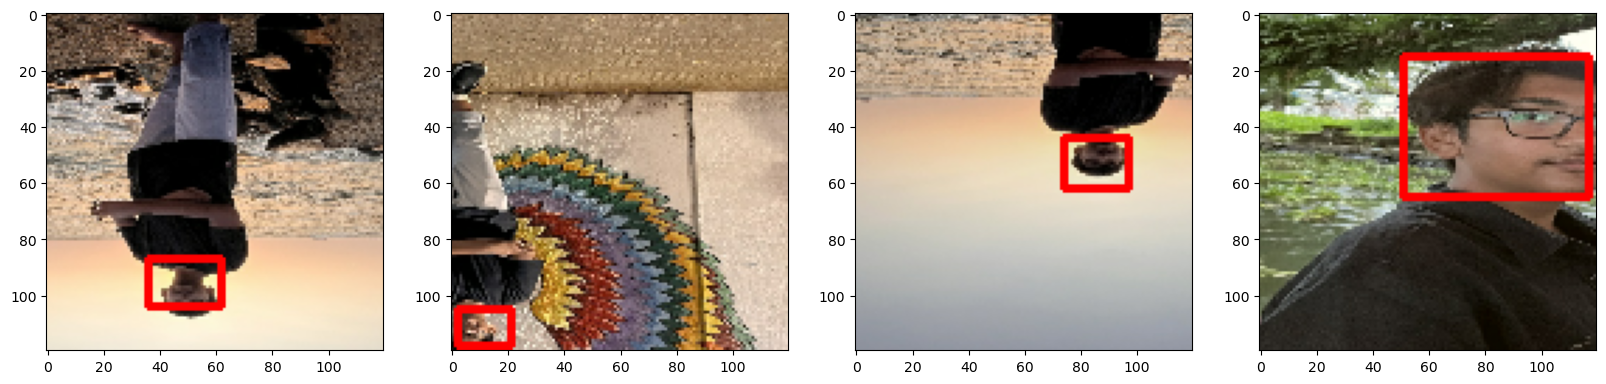

In [200]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)